## SETI Breakthrough Listen: Classification of simulated technosignature signals in cadence snippets from the Green Bank Telescope 

### A Udacity Data Science Capstone Project 

- Anomaly detection with synthetic signals injected into mid-resolution data
- Designed to mimic the search for technosignatures (alien-life) in an Radio Frequency Interference (RFI) -ridden landscape: looking for a tiny amount of anomalies (needles) in a sea of RFI (haystack)
- Samples are framed as small slices on the frequency axis from ABACAD cadences

<div>
<!-- <img src="attachment:image.png" width="400"/> -->
</div>

## Table of Contents
* [Introduction](#int)
* [Load and Clean Dataset](#load)
* [Exploratory Data Analysis](#eda)
* [Feature Engineering](#eng)
* [Modelling](#model)
* [Metrics](#metrics)
* [Conclusions](#con)

## Introduction
<a class="anchor" id="int"></a>

In this project, I will demonstrate how accurately I can identify anomalous signals from the tremendous amount of data recorded by the Green Bank Telescope using supervised machine learning classification algorithms. Since we haven’t observed any signals from extraterrestrials (officially), the dataset was artificially generated by Berkeley SETI Research Center. 

There are six observations per given star, which is part of the breakthrough listen observing technique. Three of these observations will be on target for the star, and three of them will be off target for the star: this allows us to compare these observations of on and off and see if the signal is present in both or just the on target and this is one of the common techniques used in analysis to rule out what would be local interference. 



In [1]:
# Data Wrangling
import os
from glob import glob
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # avoids too many logging messages

# Data Analysis
import math
import numpy as np # linear algebra
import pandas as pd # data processing
import sklearn
# from sklearn.manifold import TSNE

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import plotly.graph_objects as go

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.base import BaseEstimator,TransformerMixin

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

#%pip install transformers
from transformers import BertConfig, BertModel
from sklearn.tree import DecisionTreeClassifier

# import relevant functions/modules from the sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_extraction import DictVectorizer

# Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

import xgboost as xgb

# Miscellaneous
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from typing import List

print('Tensorflow version:', tf.__version__)
print('NumPy version:',np.__version__)
print('Pandas version:',pd.__version__)
print('Sklearn version:',sklearn.__version__)

Tensorflow version: 2.4.1
NumPy version: 1.19.5
Pandas version: 1.3.2
Sklearn version: 0.23.2


In [2]:
DEVICE = "TPU" #or "GPU"

In [3]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        # detect and init the TPU
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            # instantiate a distribution strategy
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    # instantiate a distribution strategy
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


### Files

**train/** - a training set of cadence snippet files stored in numpy float16 format (v1.20.1), one file per cadence snippet id, with corresponding labels found in the train_labels.csv file. Each file has dimension (6, 273, 256), with the 1st dimension representing the 6 positions of the cadence, and the 2nd and 3rd dimensions representing the 2D spectrogram.

**test/** - the test set cadence snippet files; you must predict whether or not the cadence contains a "needle", which is the target for this competition

**sample_submission.csv** - a sample submission file in the correct format

**train_labels** - targets corresponding (by id) to the cadence snippet files found in the train/ folder


In [4]:
PATH = '../input/seti-breakthrough-listen/'

### Train set

In [5]:
train_df = glob(PATH+'train/**/*.npy')
print("Number of train files:{}".format(len(train_df)))

Number of train files:60000


### Test set

In [6]:
test_df = glob(PATH+'test/**/*.npy')
print("Number of train files:{}".format(len(test_df)))

Number of train files:39995


### Sample submissions

In [7]:
sample_sub = pd.read_csv(PATH+'sample_submission.csv', nrows=1000)
sample_sub

,id,target
0,000bf832cae9ff1,0.5
1,000c74cc71a1140,0.5
2,000f5f9851161d3,0.5
3,000f7499e95aba6,0.5
4,00133ce6ec257f9,0.5
...,...,...
995,068597e1707d9e6,0.5
996,068632f10131682,0.5
997,06868def50f6170,0.5
998,068d8e8da52cf84,0.5


### Training labels 

In [8]:
# Load labels for the train data into a pandas dataframe.
train_labs = pd.read_csv(PATH+'train_labels.csv', nrows=1000)
print(train_labs.shape)
train_labs.head()

(1000, 2)


,id,target
0,0000799a2b2c42d,0
1,00042890562ff68,0
2,0005364cdcb8e5b,0
3,0007a5a46901c56,0
4,0009283e145448e,0


array([[<AxesSubplot:title={'center':'target'}>]], dtype=object)

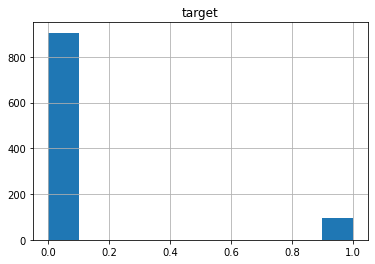

In [9]:
train_labs.hist()

#Target of 1 is positive signal
#Target of 0 is negative signal 

In [10]:
print("train df shape is ", train_labs.shape)
print("test  df shape is ", sample_sub.shape)

train df shape is  (1000, 2)
test  df shape is  (1000, 2)


In [11]:
train_labs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1000 non-null   object
 1   target  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 78.2 KB


In [12]:
train_labs.shape

(1000, 2)

# Exploratory Data Analysis

In [13]:
train_labs.describe()

,target
count,1000.000000
mean,0.094000
std,0.291975
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [14]:
train_labs.count()

id        1000
target    1000
dtype: int64

In [15]:
# Map the file id's into the corresponding file path
def get_train_file_path(image_id):
    return "/data/train/{}/{}.npy".format(image_id[0], image_id)

def get_test_file_path(image_id):
    return "/data/test/{}/{}.npy".format(image_id[0], image_id)

# train_labs['file_path'] = train_labs['id'].apply(get_train_file_path)
# sample_sub['file_path'] = sample_sub['id'].apply(get_test_file_path)

display(train_labs.head())
display(sample_sub.head())

,id,target
0,0000799a2b2c42d,0
1,00042890562ff68,0
2,0005364cdcb8e5b,0
3,0007a5a46901c56,0
4,0009283e145448e,0


,id,target
0,000bf832cae9ff1,0.5
1,000c74cc71a1140,0.5
2,000f5f9851161d3,0.5
3,000f7499e95aba6,0.5
4,00133ce6ec257f9,0.5


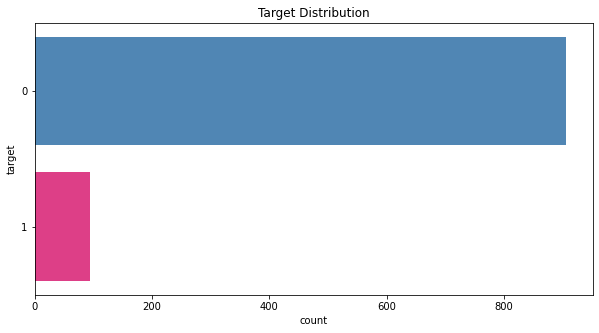

In [16]:
plt.figure(figsize=(10, 5))
sns.countplot(data=train_labs,y="target",palette=["#3F88C5","#F72585"])
plt.title("Target Distribution");

In [17]:
colors = ["#3F88C5","#F72585"]

source = train_labs['target'].value_counts()

fig = go.Figure(data=[go.Pie(labels=source.index,values=source.values, marker_colors=colors)])

fig.update_layout(title='Target distribution')

fig.show()

print("Number of records without technosignatures: "+str(train_labs["target"].value_counts()[0]))
print("Number of records with technosignatures: "+str(train_labs["target"].value_counts()[1]))

Number of records without technosignatures: 906
Number of records with technosignatures: 94


In [18]:
train_labs.target.value_counts()

0    906
1     94
Name: target, dtype: int64

In [19]:
train_labs['target'].unique()

array([0, 1])

In [20]:
pos=len(train_labs[train_labs['target']==1])
neg=len(train_labs[train_labs['target']==0])
pos/len(train_labs)

0.094

In [21]:
def get_train_filename_by_id(_id: str) -> str:
    return f"{PATH}/train/{_id[0]}/{_id}.npy"


get_train_filename_by_id(train_labs.iloc[0]["id"])

'../input/seti-breakthrough-listen//train/0/0000799a2b2c42d.npy'

In [22]:
tmp_filename = get_train_filename_by_id(train_labs.iloc[0]["id"])
arr = np.load(tmp_filename)
arr.shape

(6, 273, 256)

In [23]:
def show_cadence(filename: str, label: int) -> None:
    
    fig = plt.figure(figsize=(16, 10))
    arr = np.load(filename)
    
    for i in range(6):
        plt.subplot(6, 1, i + 1)
        if i == 0:
            
            plt.title(f"ID: {os.path.basename(filename)} TARGET: {label}", fontsize=18)
        
        plt.imshow(arr[i].astype(float), interpolation='nearest', aspect='auto', cmap='magma')
        plt.text(10, 80, ["ON", "OFF"][i % 2], bbox={'facecolor': 'white'}, size='22')
        
        fig.text(0.5, 0.03, 'Frequency ➡', ha='center', fontsize=16)
        fig.text(0.03, 0.5, '⬅ Time', va='center', rotation='vertical', fontsize=16)
        
        plt.xticks([])
    plt.show()

In [24]:
positive_target=train_labs.query("target==1").sample().id.item()
negative_target=train_labs.query("target==0").sample().id.item()

Targets with a positive signal

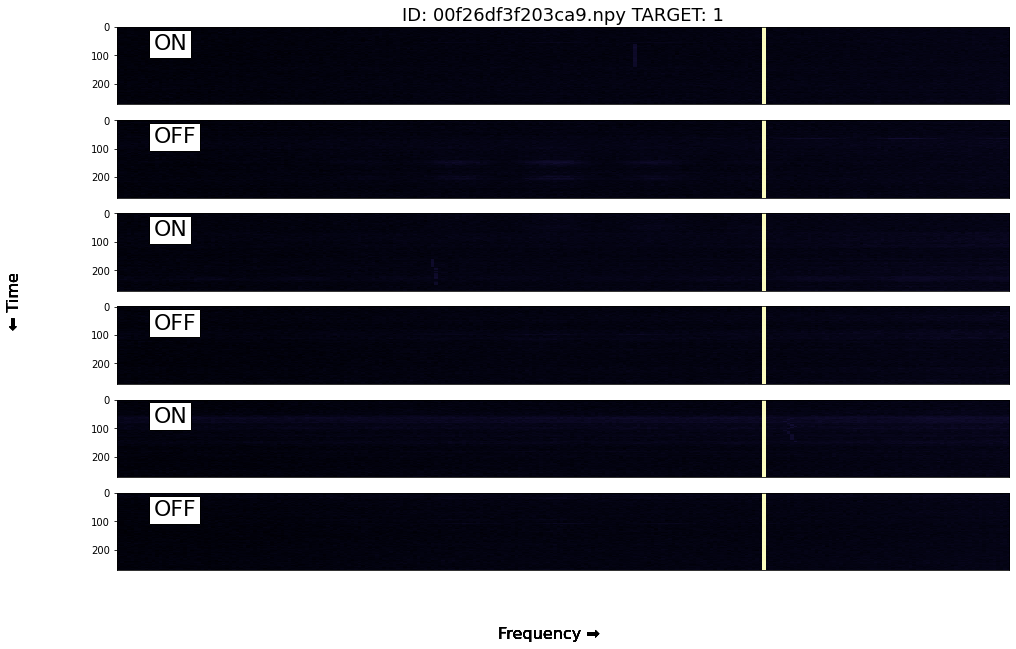

In [25]:
show_cadence(get_train_filename_by_id(positive_target), 1)


Targets with a negative signal

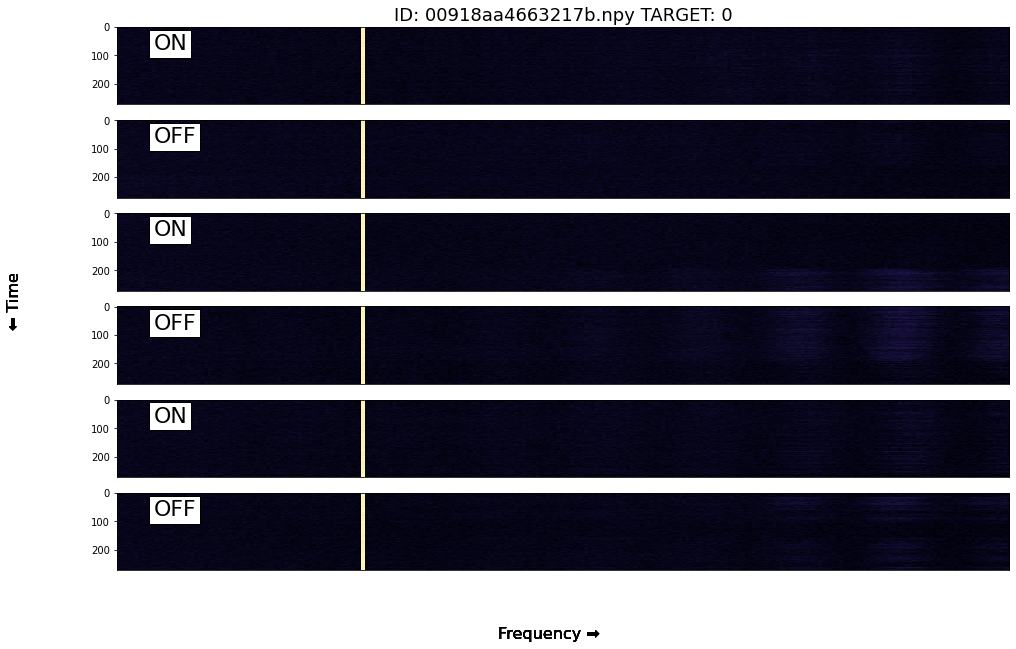

In [26]:
show_cadence(get_train_filename_by_id(negative_target), 0)

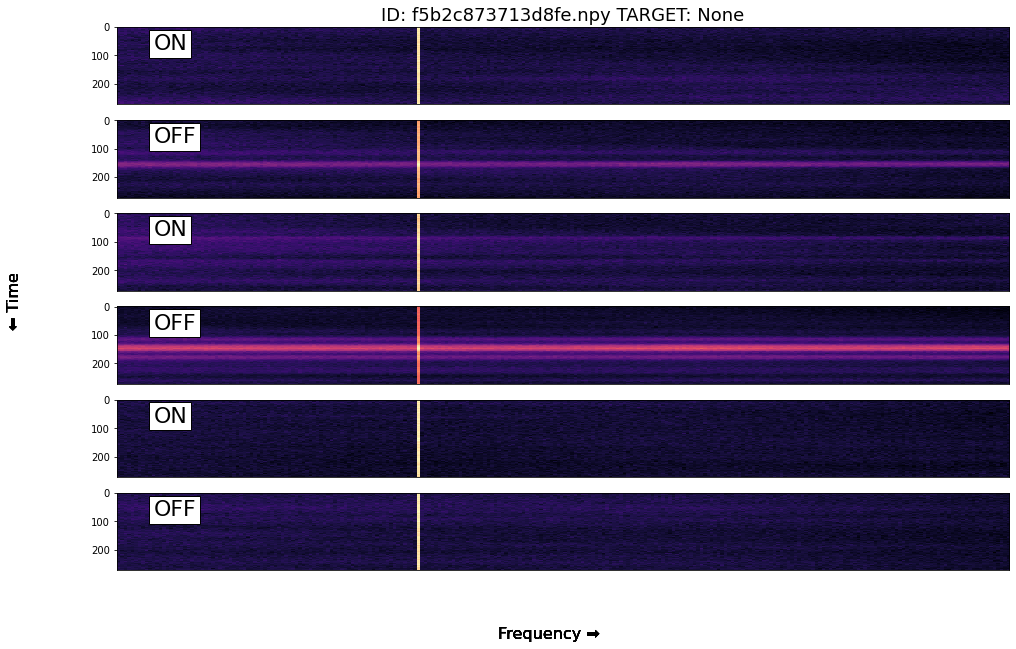

In [27]:
show_cadence(np.random.choice(test_df, 1).item(), None)

### Each sample is a set of 6 spectrograms, or a “cadence”. They are continuous in time, but the first, third, and fifth are referred to as “on target” signals that come from the target star, while the rest are “off target” signals from the nearby stars. If there is a pattern in “on target” and no pattern in “off target”, then the signal is a candidate signature of extraterrestrial technology (a positive sample)! If the pattern is also seen in “off target”, it should be a human-generated artifact (a negative sample). Here are three examples of positive cadence:

Radio Frequency Interference

RFI is emitted by our own transmitters - not just radio stations, but wifi routers, cellphones, and even electronics that are not deliberately designed to transmit radio signals. So searching for extra-terrestrial intelligence (ETI) signals, also known as "technosignatures", is very much a needle in a haystack problem. There are three main methods that we can use to weed out signals of interest.

1. The source is localized on the sky

Our basic observing strategy at GBT is:

Observe a target ("star A") from our primary target list for 5 minutes
Observe another target ("star B") at a nearby position on the sky for 5 minutes
Return to star A for 5 minutes
Observe another target ("star C") from our secondary list for 5 minutes
Another 5 minutes on star A
5 minutes on another secondary target ("star D")
We repeat this ABACAD cadence for all of the "A" stars in our primary target list (around 1700 in total, although not all of these are visible from the Green Bank Telescope site).

A signal would be interesting from a SETI standpoint if it's present in all three "A" (or ON primary source) observations, but absent in the "B/C/D" (or OFF primary source) observations. If someone was standing near the telescope with a cellphone switched on, we wouldn't expect this interference to come and go as we move on and off the primary target on the sky, so this is a good way of ruling out the local interference that makes up the majority of RFI.[https://github.com/UCBerkeleySETI/breakthrough/blob/master/GBT/README.md] 

In [28]:
def show_channels(filename: str, label: int) -> None:
    plt.figure(figsize=(16, 10))
    plt.suptitle(f"ID: {os.path.basename(filename)} TARGET: {label}", fontsize=18)
    arr = np.load(filename)
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(arr[i].astype(float),cmap='inferno')
        
        
        plt.text(10, 80, ["ON", "OFF"][i % 2], bbox={'facecolor': 'white'}, size='22')
    plt.show()

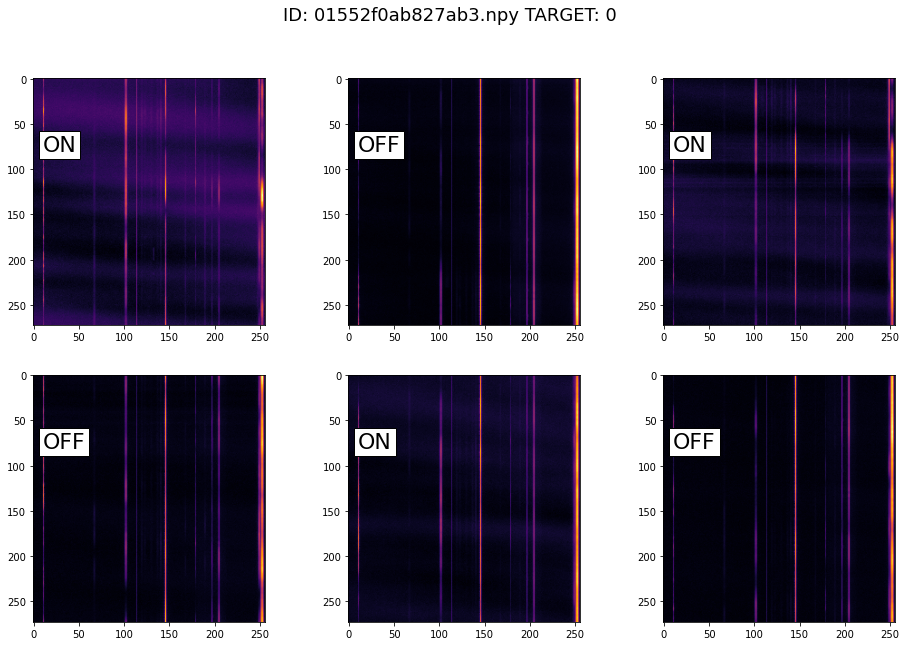

In [29]:
df_tmp = train_labs[train_labs["target"] == 0].sample(1)
for ind, row in df_tmp.iterrows():
    show_channels(get_train_filename_by_id(row["id"]), row["target"])

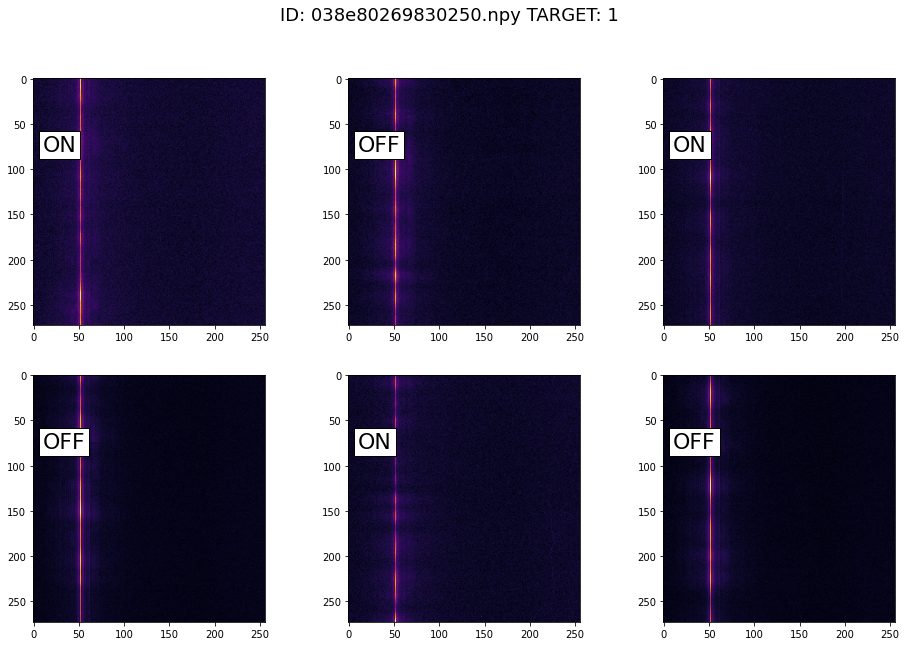

In [30]:
df_tmp = train_labs[train_labs["target"] == 1].sample(1)
for ind, row in df_tmp.iterrows():
    show_channels(get_train_filename_by_id(row["id"]), row["target"])

Three pairs of on-off waterfall plots for a particular source. Here we are just showing the output of one compute node, representing 1/8 of the total bandwidth recorded. Various RFI signals with complex frequency-time structure are seen in all six waterfall plots. If we saw some signal that appeared to be uniquely present in just the top row, and was absent in the bottom row (and perhaps also in all other stars in our primary sample) this would be of interest for follow-up.

In [31]:
train_labs['path'] = train_labs['id'].apply(lambda x: f"{PATH}train/{x[0]}/{x}.npy")
train_labs['group'] = train_labs['id'].apply(lambda x: x[0])

# Model

## Train / Test / Validation Split

In [32]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train_labs, test_size=.2, random_state=0, stratify=train_labs["group"].values, shuffle = True)
print(train.shape[0])
print(test.shape[0])

800
200


In [33]:
train_data, val_data = train_test_split(train, test_size=0.2, random_state=0)
print(train_data.shape[0])
print(val_data.shape[0])

640
160


In [34]:
def read_file(file_name):
    file=np.load(file_name)
    
    return file[:,:,:]

def character_encoder(dataset, var='target'):
    X = np.stack(train_labs['path'].apply(read_file))
    y = pd.get_dummies(train_labs[var], drop_first=False)
    return X, y

X_train, y_train = character_encoder(train_data)
X_val, y_val = character_encoder(val_data)
X_test, y_test = character_encoder(test)

print(X_train.shape, ",", y_train.shape)
print(X_val.shape, ",", y_val.shape)
print(X_test.shape, ",", y_test.shape)

(1000, 6, 273, 256) , (1000, 2)
(1000, 6, 273, 256) , (1000, 2)
(1000, 6, 273, 256) , (1000, 2)


In [35]:
with strategy.scope():
    model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(32, (5, 5), input_shape=X_train.shape[1:], padding = 'same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.LeakyReLU(alpha=0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dense(y_train.shape[1], activation='sigmoid')
    ])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 6, 273, 32)        204832    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 136, 32)        0         
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 3, 136, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 13056)             0         
_________________________________________________________________
dropout (Dropout)            (None, 13056)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               6685184   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [36]:
results = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
32/32 [==============================] - 26s 651ms/step - loss: 26.7110 - accuracy: 0.8383 - val_loss: 8.3030 - val_accuracy: 0.9060
Epoch 2/10
32/32 [==============================] - 2s 67ms/step - loss: 5.5657 - accuracy: 0.9137 - val_loss: 1.9327 - val_accuracy: 0.8990
Epoch 3/10
32/32 [==============================] - 2s 67ms/step - loss: 3.2541 - accuracy: 0.9097 - val_loss: 4.1800 - val_accuracy: 0.8870
Epoch 4/10
32/32 [==============================] - 2s 70ms/step - loss: 3.6010 - accuracy: 0.8994 - val_loss: 3.0306 - val_accuracy: 0.7480
Epoch 5/10
32/32 [==============================] - 2s 65ms/step - loss: 2.1745 - accuracy: 0.8629 - val_loss: 1.0520 - val_accuracy: 0.9440
Epoch 6/10
32/32 [==============================] - 2s 80ms/step - loss: 0.8781 - accuracy: 0.9397 - val_loss: 1.5209 - val_accuracy: 0.9280
Epoch 7/10
32/32 [==============================] - 2s 69ms/step - loss: 1.4388 - accuracy: 0.9217 - val_loss: 0.3622 - val_accuracy: 0.9520
Epoch 8/10

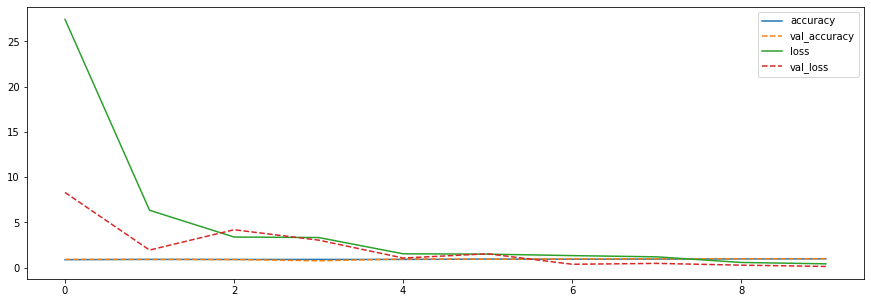

In [37]:
fig, ax = plt.subplots(figsize=(15,5))

plt.plot(results.history['accuracy'], label='accuracy')
plt.plot(results.history['val_accuracy'], label='val_accuracy', linestyle='--')
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label='val_loss', linestyle='--')
plt.legend()

In [38]:
ModelLoss, ModelAccuracy = model.evaluate(X_test, y_test)

print(f'Test Loss is {ModelLoss}')
print(f'Test Accuracy is {ModelAccuracy}')

32/32 [==============================] - 1s 26ms/step - loss: 0.1221 - accuracy: 0.9810
Test Loss is 0.12206140160560608
Test Accuracy is 0.9810000658035278


In [39]:
pred = model.predict(X_test)
pred

array([[1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [9.99757349e-01, 1.04904175e-05],
       ...,
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00]], dtype=float32)

# Pre-processing

In [40]:
for i in range(10):
    print(f"{pred[i][0]:.5f} - {pred[i][1]:.5f}")

1.00000 - 0.00000
1.00000 - 0.00000
0.99976 - 0.00001
1.00000 - 0.00000
0.99997 - 0.00000
0.99890 - 0.00003
1.00000 - 0.00000
0.99998 - 0.00000
0.83237 - 0.56878
1.00000 - 0.00000


In [41]:
# get_dummies() function is used to convert categorical variable into dummy/indicator variables.
dummies = pd.get_dummies(y_test)
y_test['All'] = dummies.cumsum(axis=1).ne(1).sum(axis=1)
y_list = y_test['All'].to_list()
y_test

,0,1,All
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
995,1,0,0
996,1,0,0
997,1,0,0
998,1,0,0


## Metrics

Random: ROC AUC=0.500
Model: ROC AUC=0.981


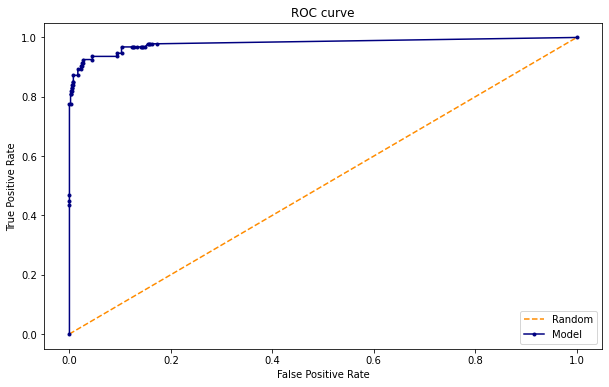

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score

rand = [0 for i in range(len(y_list))]

fpr_rand, tpr_rand, _ = roc_curve(y_list, rand)
fpr, tpr, thresholds = roc_curve(y_list, pred[:, 1])

fig = plt.figure(figsize = (10,6))
plt.plot(fpr_rand, tpr_rand, color='darkorange',linestyle='--', label='Random')
plt.plot(fpr, tpr, color='navy',marker='.', label='Model')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')

auc_rand = roc_auc_score(y_list, rand)
auc = roc_auc_score(y_list, pred[:, 1])
print(f'Random: ROC AUC={auc_rand:.3f}')
print(f'Model: ROC AUC={auc:.3f}')

Acu: 0.943


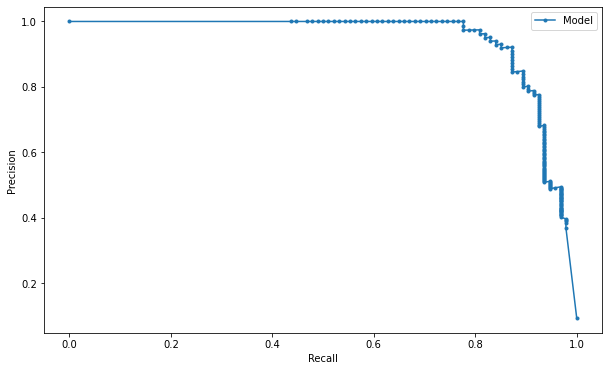

In [43]:
from sklearn.metrics import precision_recall_curve, f1_score, auc

precision, recall, _ = precision_recall_curve(y_list, pred[:, 1])
auc=auc(recall, precision)
print(f'Acu: {auc:.3f}')

fig = plt.figure(figsize = (10,6))
plt.plot(recall, precision, marker='.', label='Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

In [44]:
sample_sub['target'] = pred
sample_sub.to_csv('submission.csv', index=False)


In [45]:
sample_sub.head(500)

,id,target
0,000bf832cae9ff1,1.000000
1,000c74cc71a1140,1.000000
2,000f5f9851161d3,0.999757
3,000f7499e95aba6,1.000000
4,00133ce6ec257f9,0.999972
...,...,...
495,034c34eee1b13b3,0.995882
496,034f6978bf80436,1.000000
497,0351635339a3e2e,1.000000
498,03517f41e4f0179,1.000000
